In [1]:
import sys
sys.path.append("../classes")

In [2]:
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import numpy as np, pandas as pd
from scipy.cluster import hierarchy
from sklearn.metrics import homogeneity_completeness_v_measure

from geno_classifier import *

from itertools import starmap, product

import GEOparse

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

In [3]:
results = {}

In [4]:
def get_cancer_dataframe(results_path, labels_path, label, diff=True, pathways=True):
    c_results = pickle.load(open(results_path,'rb'))
    try:
        c_labels_ = pickle.load(open(labels_path,'rb'))["y"]
    except TypeError:
        c_labels_ = pickle.load(open(labels_path,'rb'))
    cancer, cancer_y = preprocess_results(c_results, c_labels_, 
                                                use_diff_score=diff, use_pathways=pathways, 
                                                scale=False, use_one_hot=False)

    cancer.index = starmap(change_lable, product(c_labels_, [label]))
    return cancer, c_labels_

## Clustering on diff values

In [5]:
change_lable = lambda label, prefix: '{}_{}'.format(prefix, label)

## Breast Cancer

In [6]:
breast_cancer1, bc_labels_1 = get_cancer_dataframe('../results/breast_cancer_2.results', '../datasets/breast_cancer_2_y', 'bc')

In [7]:
breast_cancer2, bc_labels_2 = get_cancer_dataframe('../results/breast_cancer3.results', '../datasets/breast_cancer3_y', 'bc')

In [8]:
breast_cancer = pd.concat([breast_cancer1])
breast_cancer[breast_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
bc_unhealthy,-25.490606,-100.777030,7.129360e-06,-55.414072,0.000007
bc_unhealthy,-21.389085,96.445184,-1.006312e-06,73.618178,-0.000001
bc_unhealthy,-29.843938,38.294390,-1.006312e-06,256.413877,-0.000001
bc_healthy,-14.526884,-100.777037,5.131799e-07,-44.661390,0.000002
bc_unhealthy,-12.184960,6.018669,5.672039e-06,-55.414075,0.000006


In [9]:
bc_labels_ = list(breast_cancer.index)

In [10]:
len(list(starmap(change_lable, product(bc_labels_, 'bc'))))

176

In [11]:
breast_cancer[breast_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
bc_unhealthy,-25.490606,-100.777030,7.129360e-06,-55.414072,0.000007
bc_unhealthy,-21.389085,96.445184,-1.006312e-06,73.618178,-0.000001
bc_unhealthy,-29.843938,38.294390,-1.006312e-06,256.413877,-0.000001
bc_healthy,-14.526884,-100.777037,5.131799e-07,-44.661390,0.000002
bc_unhealthy,-12.184960,6.018669,5.672039e-06,-55.414075,0.000006


## Lung Cancer

In [12]:
lung_cancer, lc_labels_ = get_cancer_dataframe('../results/lung_cancer_1.results', '../datasets/lung_cancer_1_y', 'lg')

In [13]:
lung_cancer[lung_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
lg_unhealthy,48.843000,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,2.642386,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,41.381614,-4.367172,-0.000006,-82.204632,-0.000011
lg_unhealthy,-3.062908,109.866720,-0.000005,-114.462695,-0.000009
lg_unhealthy,89.662783,138.648466,-0.000006,-103.710008,-0.000011


## Colon Cancer

In [14]:
colon_cancer, colon_labels_ = get_cancer_dataframe('../results/colon_cancer.results', '../datasets/colon_cancer_Xy', 'cc')

In [15]:
colon_cancer[colon_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
cc_healthy,-56.854475,81.990621,-0.000003,-20.717564,-0.000003
cc_healthy,24.866507,-51.435305,-0.000003,-20.717564,-0.000003
cc_unhealthy,-51.641041,-51.765993,-0.000003,145.949103,-0.000002
cc_healthy,-22.276013,-36.606562,0.000001,-20.717560,0.000001
cc_unhealthy,-11.444609,-113.935285,0.000025,-20.717542,0.000027


## Prostate Cancer

In [16]:
prostate_cancer, prostate_labels_ = get_cancer_dataframe('../results/prostate_cancer.results', '../datasets/prostate_cancer_Xy', 'pc')

In [17]:
prostate_cancer[prostate_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
pc_unhealthy,-73.114157,-91.998672,-0.000007,-14.836660,1.384812
pc_healthy,33.889571,44.969413,-0.000007,-36.342037,1.384812
pc_healthy,-86.516827,-80.030587,-0.000007,-36.342037,-33.702907
pc_healthy,-52.694265,81.699959,-0.000007,25.990148,1.384812
pc_unhealthy,-22.961132,-387.322253,-0.000007,92.690222,1.384812


In [18]:
classes = {'bc_unhealthy': 0, 'bc_healthy': 1, 
           'lg_unhealthy': 2, 'lg_healthy': 3, 
           'cc_healthy':4, 'cc_unhealthy': 5,
           'pc_healthy':6, 'pc_unhealthy':7}
colors = {0 : 'darkmagenta', 1 : 'lightpink',
          2 : 'grey', 3:'lightblue', 
          4:'green', 5:'red',
          6:'yellow', 7:'orange'}

labeled_colors = {k:colors[v] for k,v in classes.items()}
labeled_colors

{'bc_healthy': 'lightpink',
 'bc_unhealthy': 'darkmagenta',
 'cc_healthy': 'green',
 'cc_unhealthy': 'red',
 'lg_healthy': 'lightblue',
 'lg_unhealthy': 'grey',
 'pc_healthy': 'yellow',
 'pc_unhealthy': 'orange'}

In [19]:
dis = [breast_cancer, lung_cancer, colon_cancer, prostate_cancer]
diseases = pd.concat(dis)
n_clusters = 2**len(dis)

## PCA

{'completeness': 0.13870983717815044,
 'homogeneity': 0.17508690490093995,
 'v_measure': 0.15478985479533436}

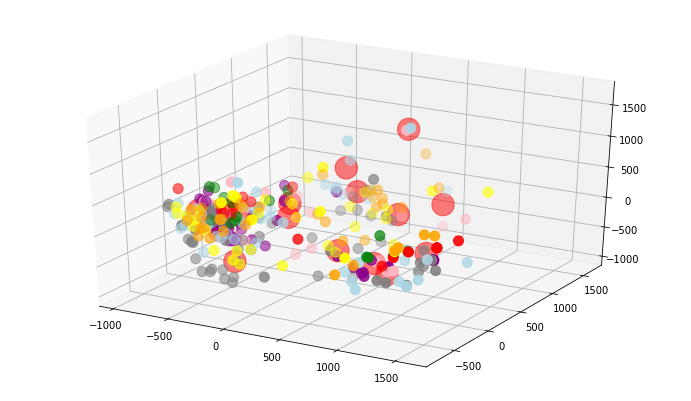

In [20]:
import matplotlib.pyplot as plt
reduced_diseases = PCA(n_components=3).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_diseases)

centers = kmeans.cluster_centers_


fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', alpha=0.5, s=500)
ax.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], reduced_diseases[:, 2], c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans.labels_)

results["Diff"] = {"3D":{"PCA":{"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}}}
results["Diff"]["3D"]["PCA"]

{'completeness': 0.14605149219978583,
 'homogeneity': 0.1925223009231004,
 'v_measure': 0.16609773055500168}

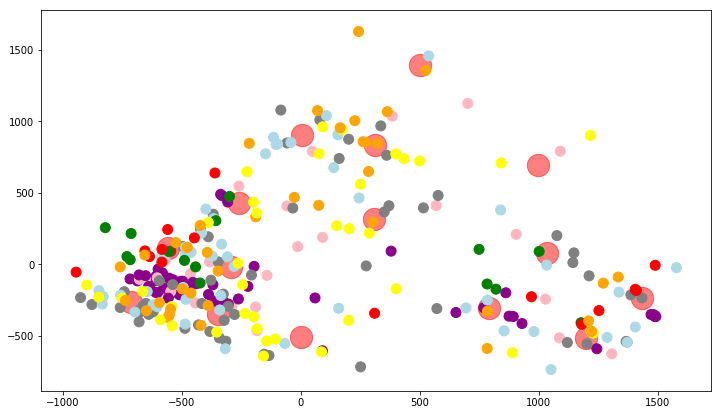

In [21]:
reduced_diseases = PCA(n_components=2).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_diseases)
plt.figure(figsize=(12, 7))

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans.labels_)

results["Diff"]["2D"] = {"PCA":{"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}}
results["Diff"]["2D"]["PCA"]

## t-SNE

{'completeness': 0.09559609381281865,
 'homogeneity': 0.13014064409218978,
 'v_measure': 0.11022518830526248}

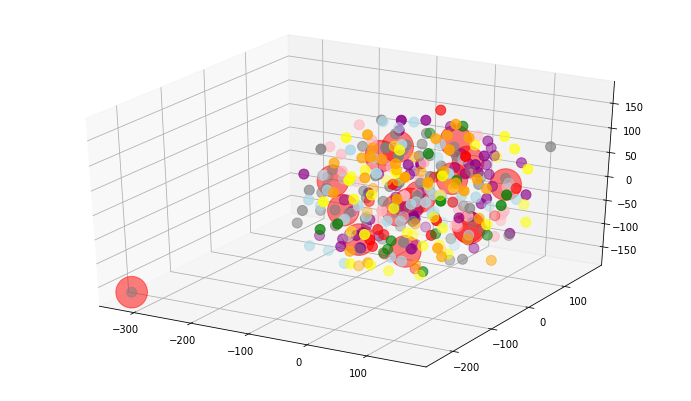

In [22]:
tsne = TSNE(n_components=3, random_state=42)
diseases_reduced_tsne = tsne.fit_transform(diseases)

kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_tsne)
centers = kmeans_tsne.cluster_centers_

fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', alpha=0.5, s=1000)
ax.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], diseases_reduced_tsne[:, 2],
            c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

results["Diff"]["3D"] ["t-SNE"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["Diff"]["3D"]["t-SNE"]

{'completeness': 0.1615518454840355,
 'homogeneity': 0.2224924149405828,
 'v_measure': 0.18718707161570083}

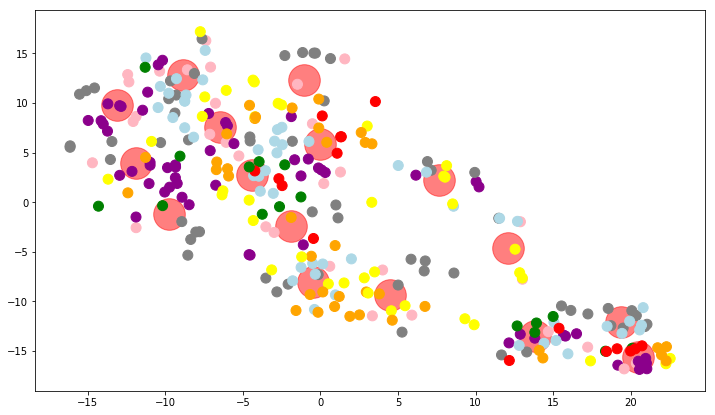

In [23]:
diseases_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(diseases)

kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_tsne)
centers = kmeans_tsne.cluster_centers_

plt.figure(figsize=(12, 7))

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=1000)
plt.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

results["Diff"]["2D"] ["t-SNE"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["Diff"]["2D"]["t-SNE"]

## LDA

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388 UserWarning: Variables are collinear.


{'completeness': 0.4331073474549416,
 'homogeneity': 0.582785014950089,
 'v_measure': 0.4969197157147003}

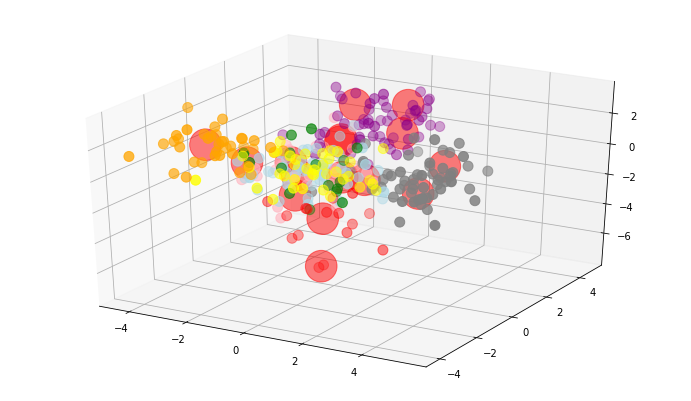

In [24]:
diseases_reduced_lda = LinearDiscriminantAnalysis(n_components=3).fit_transform(diseases, y)

kmeans_lda = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_lda)

centers = kmeans_lda.cluster_centers_

fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', alpha=0.5, s=1000)
ax.scatter(diseases_reduced_lda[:, 0], diseases_reduced_lda[:, 1], diseases_reduced_lda[:, 2],
            c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_lda.labels_)

results["Diff"]["3D"] ["LDA"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["Diff"]["3D"]["LDA"]

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388 UserWarning: Variables are collinear.


{'completeness': 0.3784308582213188,
 'homogeneity': 0.5141874476087974,
 'v_measure': 0.4359856745359198}

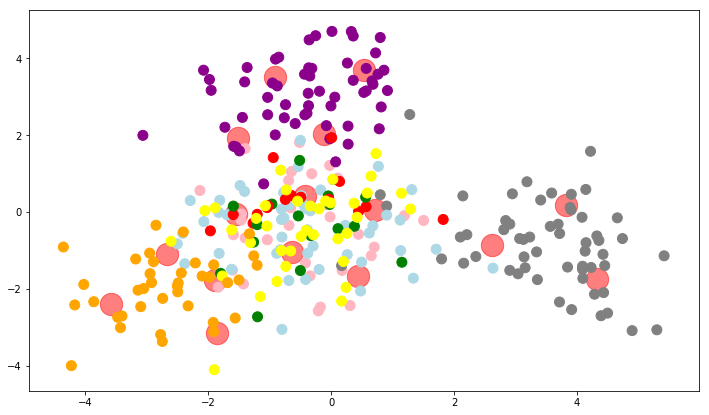

In [25]:
diseases_reduced_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(diseases, y)
kmeans_lda = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_lda)

plt.figure(figsize=(12, 7))

centers = kmeans_lda.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_lda[:, 0], diseases_reduced_lda[:, 1], c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_lda.labels_)

results["Diff"]["2D"] ["LDA"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["Diff"]["2D"]["LDA"]

## K-Best

{'completeness': 0.18005454595039536,
 'homogeneity': 0.2324061656255064,
 'v_measure': 0.2029079883409569}

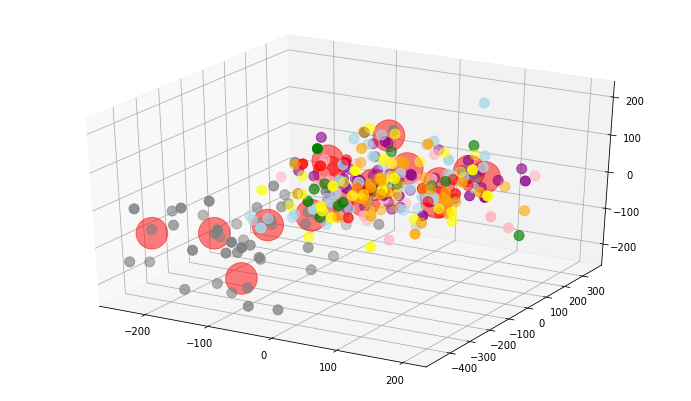

In [26]:
diseases_reduced_kbest = SelectKBest(k=3).fit_transform(diseases, y)

kmeans_kbest = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_kbest)
centers = kmeans_kbest.cluster_centers_

fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', alpha=0.5, s=1000)
ax.scatter(diseases_reduced_kbest[:, 0], diseases_reduced_kbest[:, 1], diseases_reduced_kbest[:, 2],
            c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_kbest.labels_)

results["Diff"]["3D"] ["k-best"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["Diff"]["3D"]["k-best"]

{'completeness': 0.1655816344489138,
 'homogeneity': 0.22258243383783735,
 'v_measure': 0.18989683077651462}

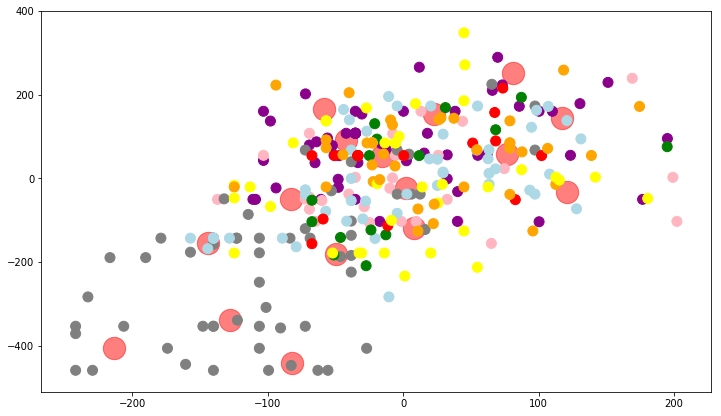

In [27]:
diseases_reduced_kbest = SelectKBest(k=2).fit_transform(diseases, y)
kmeans_kbest = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_kbest)

plt.figure(figsize=(12, 7))

centers = kmeans_kbest.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_kbest[:, 0], diseases_reduced_kbest[:, 1], c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_kbest.labels_)

results["Diff"]["2D"] ["k-best"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["Diff"]["2D"]["k-best"]

## Hierarchical clustering

In [28]:
def get_color(k, df):
    return labeled_colors[df.index[k-len(df)]]

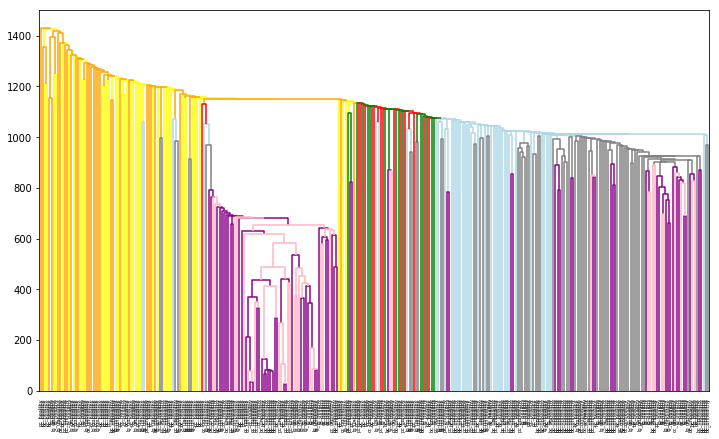

In [29]:
Z = hierarchy.linkage(diseases, method='single')
plt.figure(figsize=(12, 7))
dn = hierarchy.dendrogram(Z, labels=diseases.index, link_color_func=lambda k: get_color(k, diseases))
plt.savefig("hclustering-diff")

# Using no Diff values

In [30]:
breast_cancer_1nodiff, bc_labels_ = get_cancer_dataframe('../results/breast_cancer_2.results', '../datasets/breast_cancer_2_y', 'bc',
                                                        diff=False, pathways=False)
breast_cancer_2nodiff, bc_labels_ = get_cancer_dataframe('../results/breast_cancer3.results', '../datasets/breast_cancer3_y', 'bc',
                                                        diff=False, pathways=False)
breast_cancer_nodiff = pd.concat([breast_cancer_1nodiff])
lung_cancer_nodiff, lc_labels_ = get_cancer_dataframe('../results/lung_cancer_1.results', '../datasets/lung_cancer_1_y', 'lg',
                                               diff=False, pathways=False)
colon_cancer_nodiff, colon_labels_ = get_cancer_dataframe('../results/colon_cancer.results', '../datasets/colon_cancer_Xy', 'cc',
                                                   diff=False, pathways=False)
prostate_cancer_nodiff, prostate_labels_ = get_cancer_dataframe('../results/prostate_cancer.results', '../datasets/prostate_cancer_Xy', 'pc',
                                                         diff=False, pathways=False)

diseases_nodiff = pd.concat([breast_cancer_nodiff, lung_cancer_nodiff, colon_cancer_nodiff, prostate_cancer_nodiff])

## PCA

{'completeness': 0.13870983717815044,
 'homogeneity': 0.17508690490093995,
 'v_measure': 0.15478985479533436}

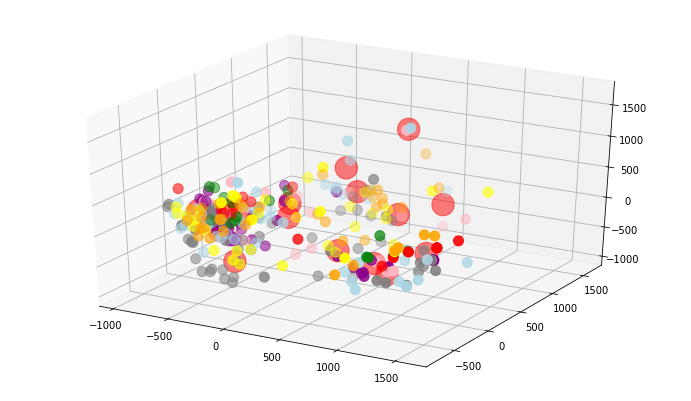

In [31]:
reduced_diseases = PCA(n_components=3).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_diseases)

centers = kmeans.cluster_centers_


fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', alpha=0.5, s=500)
ax.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], reduced_diseases[:, 2], c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans.labels_)

results["no_Diff"] = {"3D":{"PCA":{"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}}}
results["no_Diff"]["3D"]["PCA"]

{'completeness': 0.19822217972275571,
 'homogeneity': 0.26031329683629195,
 'v_measure': 0.22506380311911056}

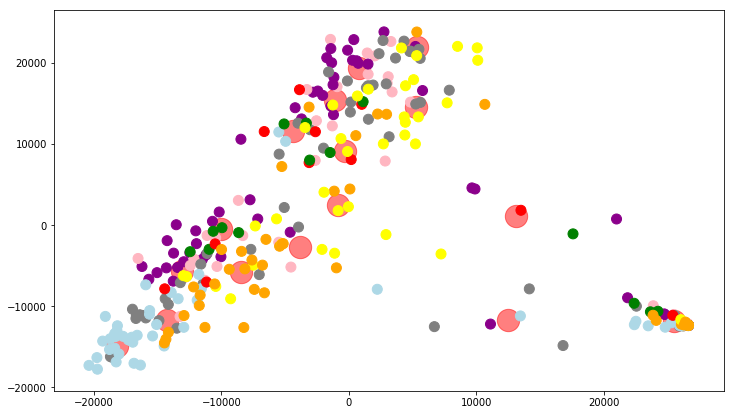

In [32]:
reduced_diseases = PCA(n_components=2).fit_transform(diseases_nodiff)

y = [classes[i] for i in np.array(diseases_nodiff.index)]
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_diseases)
plt.figure(figsize=(12, 7))

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans.labels_)

results["no_Diff"]["2D"] = {"PCA":{"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}}
results["no_Diff"]["2D"]["PCA"]

## t-SNE

{'completeness': 0.126031982653459,
 'homogeneity': 0.17412602950999112,
 'v_measure': 0.1462259732634994}

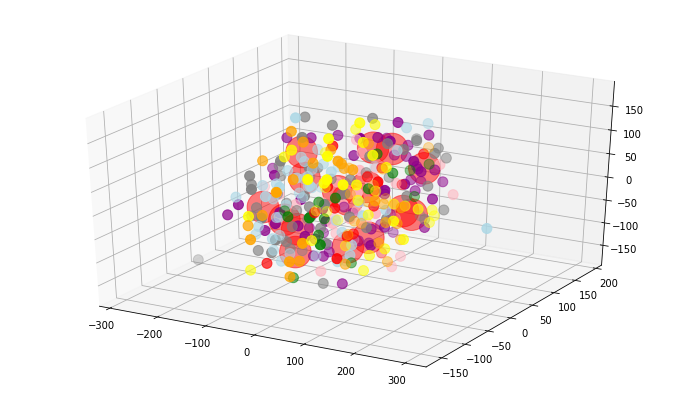

In [33]:
diseases_reduced_tsne = TSNE(n_components=3, random_state=42).fit_transform(diseases_nodiff)

kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_tsne)
centers = kmeans_tsne.cluster_centers_

fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', alpha=0.5, s=1000)
ax.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], diseases_reduced_tsne[:, 2],
            c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

results["no_Diff"]["3D"] ["t-SNE"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["no_Diff"]["3D"]["t-SNE"]

{'completeness': 0.23223593718781288,
 'homogeneity': 0.3169672827297375,
 'v_measure': 0.26806541292189073}

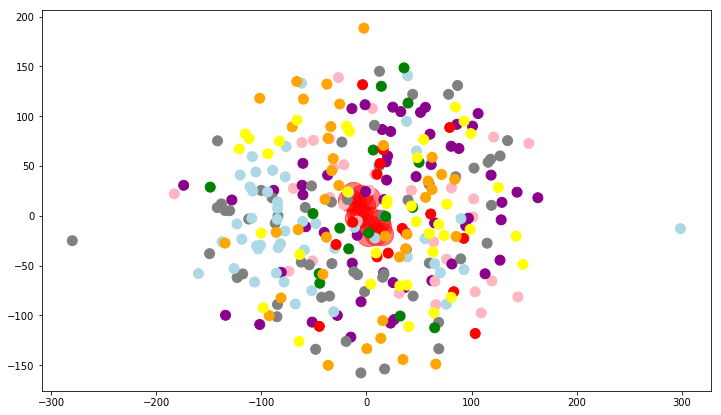

In [34]:
diseases_reduced_tsne_nodiff = TSNE(n_components=2, random_state=42).fit_transform(diseases_nodiff)
kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_tsne_nodiff)

plt.figure(figsize=(12, 7))

centers = kmeans_tsne.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

results["no_Diff"]["2D"] ["t-SNE"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["no_Diff"]["2D"]["t-SNE"]

## LDA

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388 UserWarning: Variables are collinear.


{'completeness': 0.9309023415140776,
 'homogeneity': 0.9918703055560563,
 'v_measure': 0.9604197265104296}

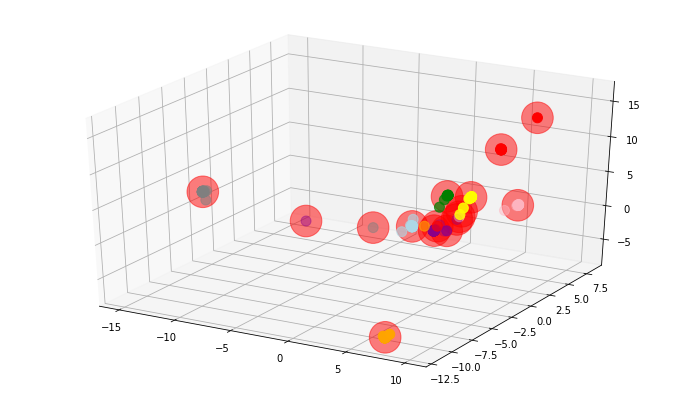

In [35]:
diseases_reduced_lda = LinearDiscriminantAnalysis(n_components=3).fit_transform(diseases_nodiff, y)

kmeans_lda = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_lda)

centers = kmeans_lda.cluster_centers_

fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', alpha=0.5, s=1000)
ax.scatter(diseases_reduced_lda[:, 0], diseases_reduced_lda[:, 1], diseases_reduced_lda[:, 2],
            c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_lda.labels_)

results["no_Diff"]["3D"] ["LDA"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["no_Diff"]["3D"]["LDA"]

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388 UserWarning: Variables are collinear.


{'completeness': 0.9242944072165787,
 'homogeneity': 0.9913934222059054,
 'v_measure': 0.9566688073311698}

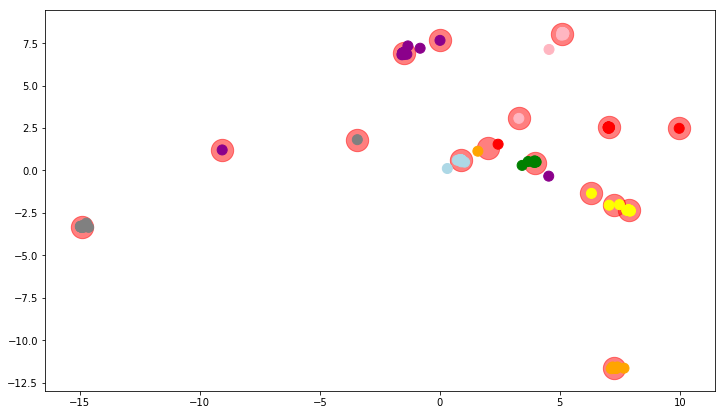

In [36]:
diseases_reduced_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(diseases_nodiff, y)
kmeans_lda = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_lda)

plt.figure(figsize=(12, 7))

centers = kmeans_lda.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_lda[:, 0], diseases_reduced_lda[:, 1], c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_lda.labels_)

results["no_Diff"]["2D"] ["LDA"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["no_Diff"]["2D"]["LDA"]

## K-Best

/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113 UserWarning: Features [115 117 129 131 143 145] are constant.
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:114 RuntimeWarning: invalid value encountered in true_divide


{'completeness': 0.3323976981168018,
 'homogeneity': 0.27253809189231937,
 'v_measure': 0.2995062811303872}

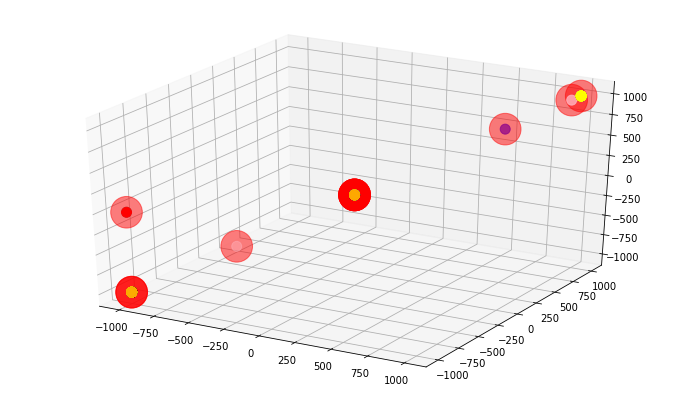

In [37]:
diseases_reduced_kbest = SelectKBest(k=3).fit_transform(diseases_nodiff, y)

kmeans_kbest = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_kbest)
centers = kmeans_kbest.cluster_centers_

fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', alpha=0.5, s=1000)
ax.scatter(diseases_reduced_kbest[:, 0], diseases_reduced_kbest[:, 1], diseases_reduced_kbest[:, 2],
            c=[colors[i] for i in y], s=100)

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, kmeans_kbest.labels_)

results["no_Diff"]["3D"] ["k-best"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["no_Diff"]["3D"]["k-best"]

/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113 UserWarning: Features [115 117 129 131 143 145] are constant.
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:114 RuntimeWarning: invalid value encountered in true_divide


{'completeness': 0.3323976981168018,
 'homogeneity': 0.27253809189231937,
 'v_measure': 0.2995062811303872}

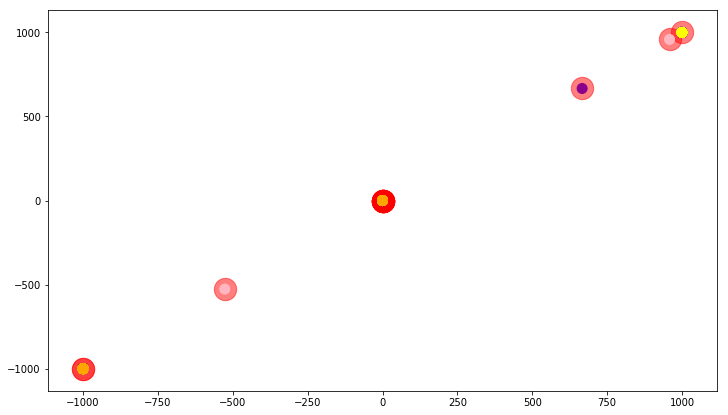

In [38]:
diseases_reduced_kbest = SelectKBest(k=2).fit_transform(diseases_nodiff, y)
kmeans_kbest = KMeans(n_clusters=n_clusters, random_state=42).fit(diseases_reduced_kbest)
plt.figure(figsize=(12, 7))

centers = kmeans_kbest.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_kbest[:, 0], diseases_reduced_kbest[:, 1], c=[colors[i] for i in y], s=100)

homogeneity_completeness_v_measure(y, kmeans_kbest.labels_)

results["no_Diff"]["2D"] ["k-best"] = {"homogeneity":homogeneity,
                  "completeness":completeness,
                  "v_measure": v_measure}
results["no_Diff"]["2D"]["k-best"]

## Hierarchical clustering

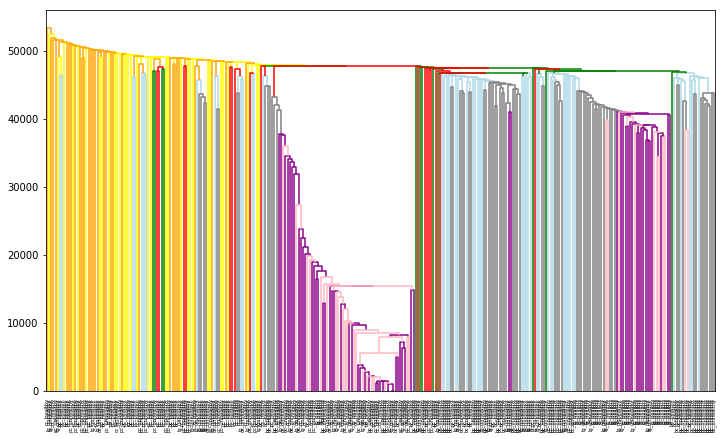

In [39]:
Z = hierarchy.linkage(diseases_nodiff, method='single')
plt.figure(figsize=(12, 7))
dn = hierarchy.dendrogram(Z, labels=diseases_nodiff.index, link_color_func=lambda k:get_color(k, diseases_nodiff))
plt.savefig("hclustering-nodiff")

In [40]:
diff_2d = pd.DataFrame(results["Diff"]["2D"])
diff_2d.rename(columns={col:col+"_2d" for col in diff_2d.columns}, inplace=True)

diff_3d = pd.DataFrame(results["Diff"]["3D"])
diff_3d.rename(columns={col:col+"_3d" for col in diff_3d.columns}, inplace=True)

pd.concat([diff_2d, diff_3d], axis=1)

,LDA_2d,PCA_2d,k-best_2d,t-SNE_2d,LDA_3d,PCA_3d,k-best_3d,t-SNE_3d
completeness,0.378431,0.146051,0.165582,0.161552,0.433107,0.138710,0.180055,0.095596
homogeneity,0.514187,0.192522,0.222582,0.222492,0.582785,0.175087,0.232406,0.130141
v_measure,0.435986,0.166098,0.189897,0.187187,0.496920,0.154790,0.202908,0.110225


In [42]:
nodiff_2d = pd.DataFrame(results["no_Diff"]["2D"])
nodiff_2d.rename(columns={col:col+"_2d" for col in nodiff_2d.columns}, inplace=True)

nodiff_3d = pd.DataFrame(results["no_Diff"]["3D"])
nodiff_3d.rename(columns={col:col+"_3d" for col in nodiff_3d.columns}, inplace=True)

pd.concat([nodiff_2d, nodiff_3d], axis=1)

,LDA_2d,PCA_2d,k-best_2d,t-SNE_2d,LDA_3d,PCA_3d,k-best_3d,t-SNE_3d
completeness,0.924294,0.198222,0.332398,0.232236,0.930902,0.138710,0.332398,0.126032
homogeneity,0.991393,0.260313,0.272538,0.316967,0.991870,0.175087,0.272538,0.174126
v_measure,0.956669,0.225064,0.299506,0.268065,0.960420,0.154790,0.299506,0.146226
